CA mean Dust swvl1:      0.1213
CA mean Dust−Clim swvl1: 0.0017


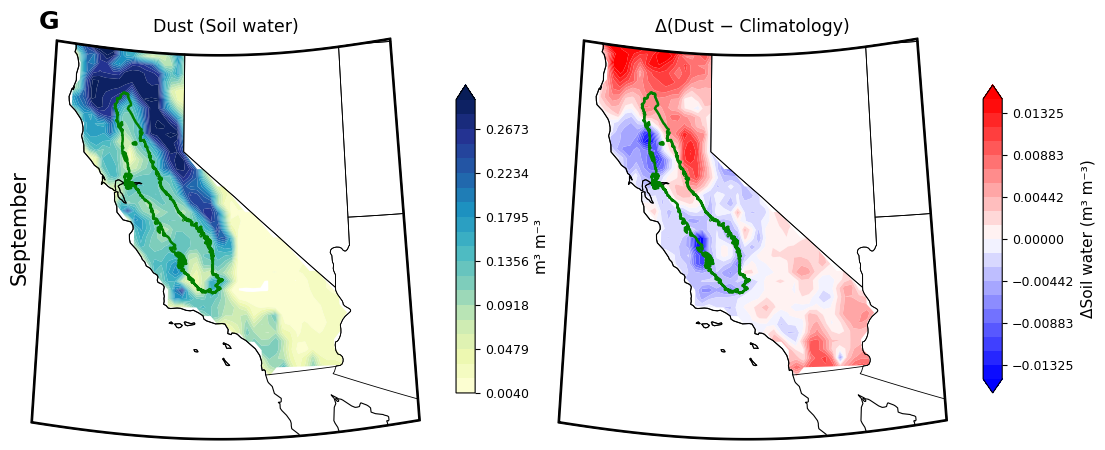

In [47]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "s_clim_soil.nc"       # swvl1(time, lat, lon)
DUSTY_NC  = "s_soil_dust.nc"      # swvl1 or swvl1_contains/prior (time, lat, lon)
VAR       = "swvl1"
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "Soil-september.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

# =======================
# Load DUST
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = VAR if VAR in ds_dust.data_vars else (
            f"{VAR}_contains" if f"{VAR}_contains" in ds_dust.data_vars else
            f"{VAR}_prior"    if f"{VAR}_prior"    in ds_dust.data_vars else None)
if dust_name is None:
    raise ValueError(f"Dust file must have '{VAR}', '{VAR}_contains', or '{VAR}_prior'.")

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust_mean = dust.mean("time", keep_attrs=True)

# =======================
# Load CLIM
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
soil = ds[VAR].transpose("time","lat","lon")
soil = fix_lon_range(soil).sortby("time")

if YEARS is not None:
    t = pd.to_datetime(soil["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        soil = soil.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(soil.lon.values, dust.lon.values) and np.array_equal(soil.lat.values, dust.lat.values)):
    soil = soil.interp(lon=dust.lon, lat=dust.lat)

clim_mean = soil.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust swvl1:      {area_weighted_mean_2d(dust_ca):.4f}")
print(f"CA mean Dust−Clim swvl1: {area_weighted_mean_2d(anom_ca):.4f}")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-8)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — Dust first, Dust−Climatology second (with spacer + two CBs)
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw panels
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",
                   "Dust (Soil water)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both",
                   "Δ(Dust − Climatology)")

# Colorbars (shorter + slightly narrower so they don't crowd panels)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "m³ m⁻³")
adjust_cbar(cax_anom, cf_anom, "ΔSoil water (m³ m⁻³)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "G",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "September", rotation=90,
         va="center", ha="center", fontsize=15)



fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()



CA mean Dust swvl1:      0.1489
CA mean Dust−Clim swvl1: 0.0027


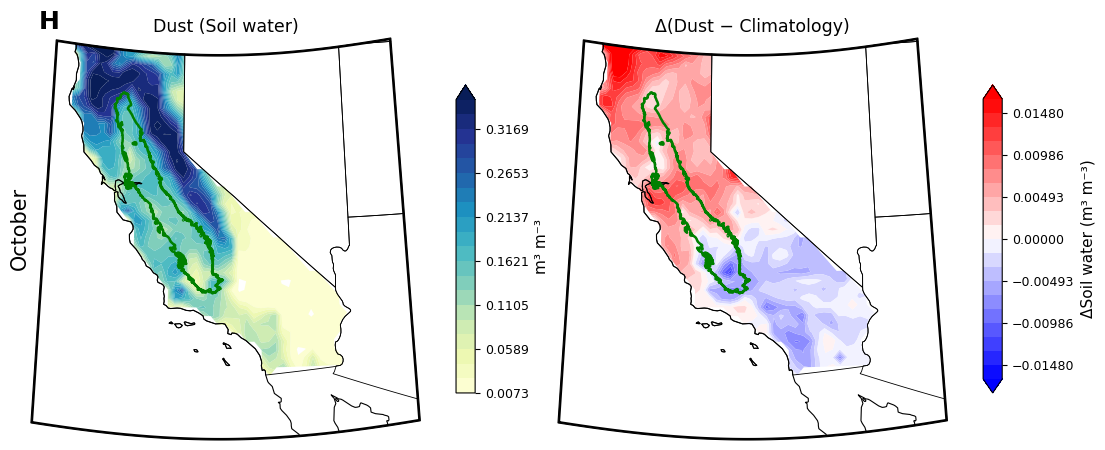

In [48]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "o_clim_soil.nc"       # swvl1(time, lat, lon)
DUSTY_NC  = "o_soil_dust.nc"      # swvl1 or swvl1_contains/prior (time, lat, lon)
VAR       = "swvl1"
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "Soil-october.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

# =======================
# Load DUST
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = VAR if VAR in ds_dust.data_vars else (
            f"{VAR}_contains" if f"{VAR}_contains" in ds_dust.data_vars else
            f"{VAR}_prior"    if f"{VAR}_prior"    in ds_dust.data_vars else None)
if dust_name is None:
    raise ValueError(f"Dust file must have '{VAR}', '{VAR}_contains', or '{VAR}_prior'.")

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust_mean = dust.mean("time", keep_attrs=True)

# =======================
# Load CLIM
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
soil = ds[VAR].transpose("time","lat","lon")
soil = fix_lon_range(soil).sortby("time")

if YEARS is not None:
    t = pd.to_datetime(soil["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        soil = soil.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(soil.lon.values, dust.lon.values) and np.array_equal(soil.lat.values, dust.lat.values)):
    soil = soil.interp(lon=dust.lon, lat=dust.lat)

clim_mean = soil.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust swvl1:      {area_weighted_mean_2d(dust_ca):.4f}")
print(f"CA mean Dust−Clim swvl1: {area_weighted_mean_2d(anom_ca):.4f}")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-8)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — Dust first, Dust−Climatology second (with spacer + two CBs)
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw panels
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",
                   "Dust (Soil water)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both",
                   "Δ(Dust − Climatology)")

# Colorbars (shorter + slightly narrower so they don't crowd panels)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "m³ m⁻³")
adjust_cbar(cax_anom, cf_anom, "ΔSoil water (m³ m⁻³)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "H",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "October", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()



CA mean Dust swvl1:      0.1792
CA mean Dust−Clim swvl1: -0.0125


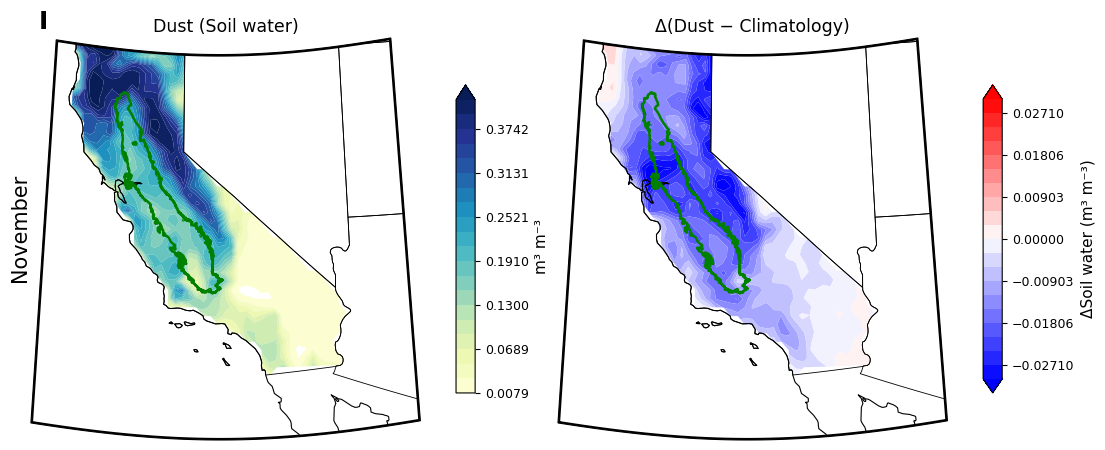

In [49]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "n_clim_soil.nc"       # swvl1(time, lat, lon)
DUSTY_NC  = "n_soil_dust.nc"      # swvl1 or swvl1_contains/prior (time, lat, lon)
VAR       = "swvl1"
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "Soil-november.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

# =======================
# Load DUST
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = VAR if VAR in ds_dust.data_vars else (
            f"{VAR}_contains" if f"{VAR}_contains" in ds_dust.data_vars else
            f"{VAR}_prior"    if f"{VAR}_prior"    in ds_dust.data_vars else None)
if dust_name is None:
    raise ValueError(f"Dust file must have '{VAR}', '{VAR}_contains', or '{VAR}_prior'.")

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust_mean = dust.mean("time", keep_attrs=True)

# =======================
# Load CLIM
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
soil = ds[VAR].transpose("time","lat","lon")
soil = fix_lon_range(soil).sortby("time")

if YEARS is not None:
    t = pd.to_datetime(soil["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        soil = soil.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(soil.lon.values, dust.lon.values) and np.array_equal(soil.lat.values, dust.lat.values)):
    soil = soil.interp(lon=dust.lon, lat=dust.lat)

clim_mean = soil.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust swvl1:      {area_weighted_mean_2d(dust_ca):.4f}")
print(f"CA mean Dust−Clim swvl1: {area_weighted_mean_2d(anom_ca):.4f}")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-8)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — Dust first, Dust−Climatology second (with spacer + two CBs)
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw panels
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",
                   "Dust (Soil water)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both",
                   "Δ(Dust − Climatology)")

# Colorbars (shorter + slightly narrower so they don't crowd panels)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "m³ m⁻³")
adjust_cbar(cax_anom, cf_anom, "ΔSoil water (m³ m⁻³)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "I",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "November", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()



CA mean Dust RH:        38.3 %
CA mean Dust−Clim RH:   -5.99 %


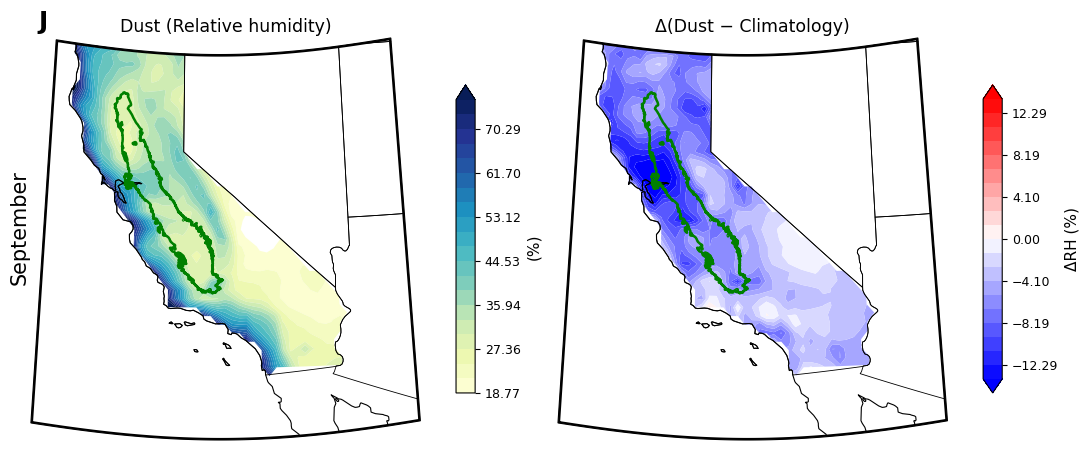

Saved: sep_rh.png


In [50]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "s_clim_rh_all.nc"     # RH on (time|day|valid_time, lat, lon)
DUSTY_NC  = "s_rh_dusty.nc"        # RH on (time|day|valid_time, lat, lon)
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "sep_rh.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_rh_var(ds: xr.Dataset):
    pref = ["rh", "hurs", "relative_humidity", "RH", "relh"]
    for vn in pref:
        if vn in ds.data_vars:
            return vn
    # fallback to first 3D var
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_percent_if_fraction(da: xr.DataArray) -> xr.DataArray:
    """Convert fractional RH (0–1) to percent, else keep as-is."""
    units = str(da.attrs.get("units", "")).lower()
    med = float(np.nanmedian(da.values)) if da.size > 0 else np.nan
    if ("%" in units) or ("percent" in units):
        return da
    if np.isfinite(med) and med <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    q98 = float(np.nanpercentile(np.abs(da.values), 98)) if da.size > 0 else np.nan
    if np.isfinite(q98) and q98 <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    if "units" not in da.attrs:
        da.attrs["units"] = "%"
    return da

# =======================
# Load DUST (RH)
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = pick_rh_var(ds_dust)

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust = to_percent_if_fraction(dust)

# =======================
# Load CLIM (RH)
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
var_name = pick_rh_var(ds)

rh = ds[var_name].transpose("time","lat","lon")
rh = fix_lon_range(rh).sortby("time")
rh = to_percent_if_fraction(rh)

# Optional time filter
if YEARS is not None:
    t = pd.to_datetime(rh["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        rh   = rh.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(rh.lon.values, dust.lon.values) and np.array_equal(rh.lat.values, dust.lat.values)):
    rh = rh.interp(lon=dust.lon, lat=dust.lat)

# Means and anomaly
dust_mean = dust.mean("time", keep_attrs=True)
clim_mean = rh.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust RH:        {area_weighted_mean_2d(dust_ca):.1f} %")
print(f"CA mean Dust−Clim RH:   {area_weighted_mean_2d(anom_ca):.2f} %")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-6)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — add spacer so first colorbar doesn't touch panel 2
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw maps
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",  "Dust (Relative humidity)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both", "Δ(Dust − Climatology)")

# Colorbars (shorter + a tad narrower)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "(%)")
adjust_cbar(cax_anom, cf_anom, "ΔRH (%)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "J",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "September", rotation=90,
         va="center", ha="center", fontsize=15)


fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


CA mean Dust RH:        45.3 %
CA mean Dust−Clim RH:   -4.17 %


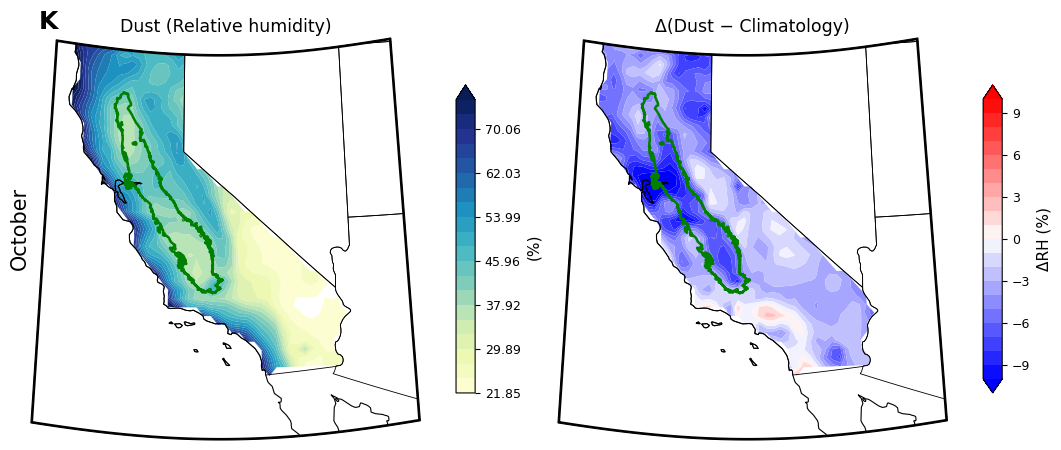

Saved: oct_rh.png


In [51]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "o_clim_rh_all.nc"     # RH on (time|day|valid_time, lat, lon)
DUSTY_NC  = "o_rh_dusty.nc"        # RH on (time|day|valid_time, lat, lon)
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "oct_rh.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_rh_var(ds: xr.Dataset):
    pref = ["rh", "hurs", "relative_humidity", "RH", "relh"]
    for vn in pref:
        if vn in ds.data_vars:
            return vn
    # fallback to first 3D var
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_percent_if_fraction(da: xr.DataArray) -> xr.DataArray:
    """Convert fractional RH (0–1) to percent, else keep as-is."""
    units = str(da.attrs.get("units", "")).lower()
    med = float(np.nanmedian(da.values)) if da.size > 0 else np.nan
    if ("%" in units) or ("percent" in units):
        return da
    if np.isfinite(med) and med <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    q98 = float(np.nanpercentile(np.abs(da.values), 98)) if da.size > 0 else np.nan
    if np.isfinite(q98) and q98 <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    if "units" not in da.attrs:
        da.attrs["units"] = "%"
    return da

# =======================
# Load DUST (RH)
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = pick_rh_var(ds_dust)

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust = to_percent_if_fraction(dust)

# =======================
# Load CLIM (RH)
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
var_name = pick_rh_var(ds)

rh = ds[var_name].transpose("time","lat","lon")
rh = fix_lon_range(rh).sortby("time")
rh = to_percent_if_fraction(rh)

# Optional time filter
if YEARS is not None:
    t = pd.to_datetime(rh["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        rh   = rh.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(rh.lon.values, dust.lon.values) and np.array_equal(rh.lat.values, dust.lat.values)):
    rh = rh.interp(lon=dust.lon, lat=dust.lat)

# Means and anomaly
dust_mean = dust.mean("time", keep_attrs=True)
clim_mean = rh.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust RH:        {area_weighted_mean_2d(dust_ca):.1f} %")
print(f"CA mean Dust−Clim RH:   {area_weighted_mean_2d(anom_ca):.2f} %")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-6)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — add spacer so first colorbar doesn't touch panel 2
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw maps
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",  "Dust (Relative humidity)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both", "Δ(Dust − Climatology)")

# Colorbars (shorter + a tad narrower)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "(%)")
adjust_cbar(cax_anom, cf_anom, "ΔRH (%)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "K",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "October", rotation=90,
         va="center", ha="center", fontsize=15)


fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


CA mean Dust RH:        50.1 %
CA mean Dust−Clim RH:   -7.74 %


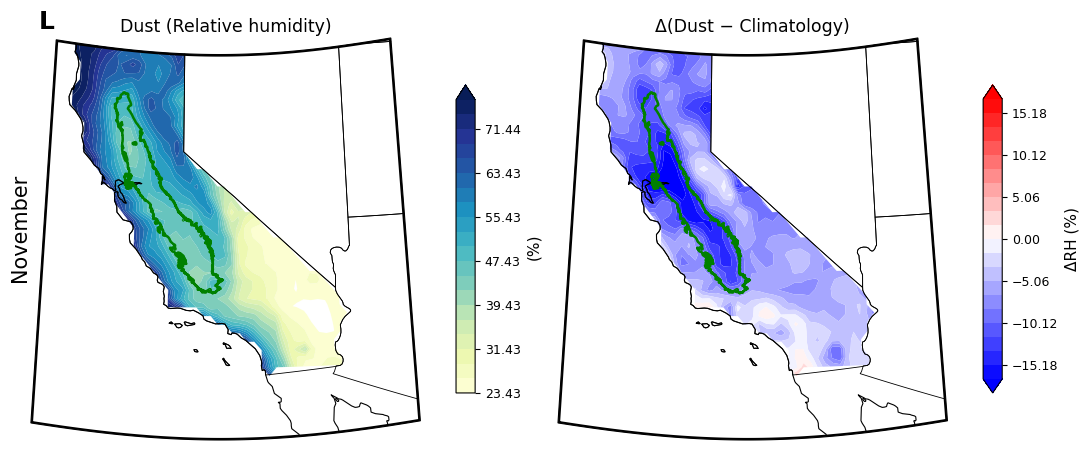

Saved: nov_rh.png


In [52]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "n_clim_rh_all.nc"     # RH on (time|day|valid_time, lat, lon)
DUSTY_NC  = "n_rh_dusty.nc"        # RH on (time|day|valid_time, lat, lon)
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "nov_rh.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_rh_var(ds: xr.Dataset):
    pref = ["rh", "hurs", "relative_humidity", "RH", "relh"]
    for vn in pref:
        if vn in ds.data_vars:
            return vn
    # fallback to first 3D var
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_percent_if_fraction(da: xr.DataArray) -> xr.DataArray:
    """Convert fractional RH (0–1) to percent, else keep as-is."""
    units = str(da.attrs.get("units", "")).lower()
    med = float(np.nanmedian(da.values)) if da.size > 0 else np.nan
    if ("%" in units) or ("percent" in units):
        return da
    if np.isfinite(med) and med <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    q98 = float(np.nanpercentile(np.abs(da.values), 98)) if da.size > 0 else np.nan
    if np.isfinite(q98) and q98 <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    if "units" not in da.attrs:
        da.attrs["units"] = "%"
    return da

# =======================
# Load DUST (RH)
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = pick_rh_var(ds_dust)

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust = to_percent_if_fraction(dust)

# =======================
# Load CLIM (RH)
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
var_name = pick_rh_var(ds)

rh = ds[var_name].transpose("time","lat","lon")
rh = fix_lon_range(rh).sortby("time")
rh = to_percent_if_fraction(rh)

# Optional time filter
if YEARS is not None:
    t = pd.to_datetime(rh["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        rh   = rh.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(rh.lon.values, dust.lon.values) and np.array_equal(rh.lat.values, dust.lat.values)):
    rh = rh.interp(lon=dust.lon, lat=dust.lat)

# Means and anomaly
dust_mean = dust.mean("time", keep_attrs=True)
clim_mean = rh.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust RH:        {area_weighted_mean_2d(dust_ca):.1f} %")
print(f"CA mean Dust−Clim RH:   {area_weighted_mean_2d(anom_ca):.2f} %")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-6)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — add spacer so first colorbar doesn't touch panel 2
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw maps
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",  "Dust (Relative humidity)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both", "Δ(Dust − Climatology)")

# Colorbars (shorter + a tad narrower)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "(%)")
adjust_cbar(cax_anom, cf_anom, "ΔRH (%)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "L",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "November", rotation=90,
         va="center", ha="center", fontsize=15)


fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


CA mean Dust RH:        27.9 %
CA mean Dust−Clim RH:   9.42 %


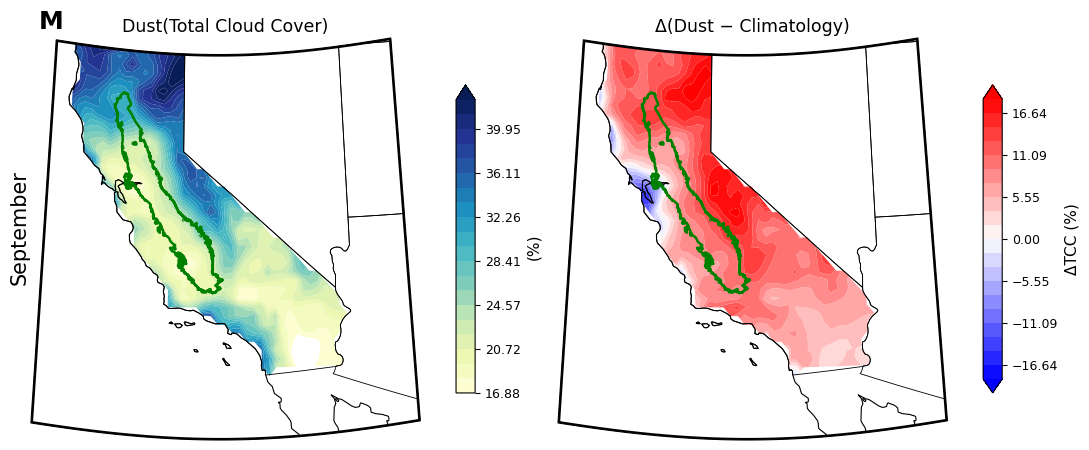

Saved: sep_cloud.png


In [53]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "s_clim_cloud.nc"     # RH on (time|day|valid_time, lat, lon)
DUSTY_NC  = "s_dusty_cloud.nc"        # RH on (time|day|valid_time, lat, lon)
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "sep_cloud.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_rh_var(ds: xr.Dataset):
    pref = ["tcc", "hurs", "relative_humidity", "RH", "relh"]
    for vn in pref:
        if vn in ds.data_vars:
            return vn
    # fallback to first 3D var
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_percent_if_fraction(da: xr.DataArray) -> xr.DataArray:
    """Convert fractional RH (0–1) to percent, else keep as-is."""
    units = str(da.attrs.get("units", "")).lower()
    med = float(np.nanmedian(da.values)) if da.size > 0 else np.nan
    if ("%" in units) or ("percent" in units):
        return da
    if np.isfinite(med) and med <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    q98 = float(np.nanpercentile(np.abs(da.values), 98)) if da.size > 0 else np.nan
    if np.isfinite(q98) and q98 <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    if "units" not in da.attrs:
        da.attrs["units"] = "%"
    return da

# =======================
# Load DUST (RH)
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = pick_rh_var(ds_dust)

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust = to_percent_if_fraction(dust)

# =======================
# Load CLIM (RH)
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
var_name = pick_rh_var(ds)

rh = ds[var_name].transpose("time","lat","lon")
rh = fix_lon_range(rh).sortby("time")
rh = to_percent_if_fraction(rh)

# Optional time filter
if YEARS is not None:
    t = pd.to_datetime(rh["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        rh   = rh.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(rh.lon.values, dust.lon.values) and np.array_equal(rh.lat.values, dust.lat.values)):
    rh = rh.interp(lon=dust.lon, lat=dust.lat)

# Means and anomaly
dust_mean = dust.mean("time", keep_attrs=True)
clim_mean = rh.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust RH:        {area_weighted_mean_2d(dust_ca):.1f} %")
print(f"CA mean Dust−Clim RH:   {area_weighted_mean_2d(anom_ca):.2f} %")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-6)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — add spacer so first colorbar doesn't touch panel 2
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw maps
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",  "Dust(Total Cloud Cover)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both", "Δ(Dust − Climatology)")

# Colorbars (shorter + a tad narrower)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "(%)")
adjust_cbar(cax_anom, cf_anom, "ΔTCC (%)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "M",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "September", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


CA mean Dust RH:        33.6 %
CA mean Dust−Clim RH:   5.68 %


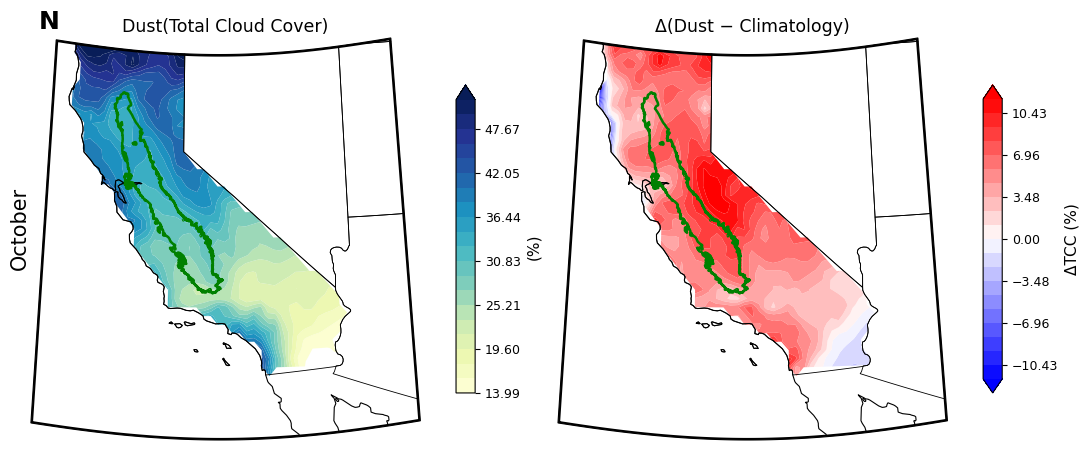

Saved: oct_cloud.png


In [54]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "o_clim_cloud.nc"     # RH on (time|day|valid_time, lat, lon)
DUSTY_NC  = "o_dusty_cloud.nc"        # RH on (time|day|valid_time, lat, lon)
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "oct_cloud.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_rh_var(ds: xr.Dataset):
    pref = ["tcc", "hurs", "relative_humidity", "RH", "relh"]
    for vn in pref:
        if vn in ds.data_vars:
            return vn
    # fallback to first 3D var
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_percent_if_fraction(da: xr.DataArray) -> xr.DataArray:
    """Convert fractional RH (0–1) to percent, else keep as-is."""
    units = str(da.attrs.get("units", "")).lower()
    med = float(np.nanmedian(da.values)) if da.size > 0 else np.nan
    if ("%" in units) or ("percent" in units):
        return da
    if np.isfinite(med) and med <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    q98 = float(np.nanpercentile(np.abs(da.values), 98)) if da.size > 0 else np.nan
    if np.isfinite(q98) and q98 <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    if "units" not in da.attrs:
        da.attrs["units"] = "%"
    return da

# =======================
# Load DUST (RH)
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = pick_rh_var(ds_dust)

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust = to_percent_if_fraction(dust)

# =======================
# Load CLIM (RH)
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
var_name = pick_rh_var(ds)

rh = ds[var_name].transpose("time","lat","lon")
rh = fix_lon_range(rh).sortby("time")
rh = to_percent_if_fraction(rh)

# Optional time filter
if YEARS is not None:
    t = pd.to_datetime(rh["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        rh   = rh.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(rh.lon.values, dust.lon.values) and np.array_equal(rh.lat.values, dust.lat.values)):
    rh = rh.interp(lon=dust.lon, lat=dust.lat)

# Means and anomaly
dust_mean = dust.mean("time", keep_attrs=True)
clim_mean = rh.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust RH:        {area_weighted_mean_2d(dust_ca):.1f} %")
print(f"CA mean Dust−Clim RH:   {area_weighted_mean_2d(anom_ca):.2f} %")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-6)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — add spacer so first colorbar doesn't touch panel 2
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw maps
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",  "Dust(Total Cloud Cover)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both", "Δ(Dust − Climatology)")

# Colorbars (shorter + a tad narrower)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "(%)")
adjust_cbar(cax_anom, cf_anom, "ΔTCC (%)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "N",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "October", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


CA mean Dust RH:        46.0 %
CA mean Dust−Clim RH:   3.72 %


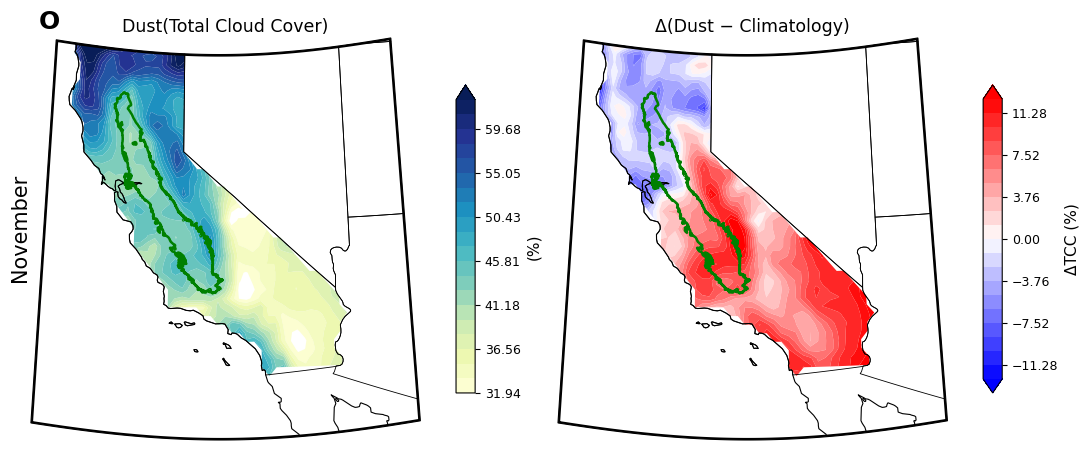

Saved: nov_cloud.png


In [55]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_NC   = "n_clim_cloud.nc"     # RH on (time|day|valid_time, lat, lon)
DUSTY_NC  = "n_dusty_cloud.nc"        # RH on (time|day|valid_time, lat, lon)
YEARS     = (2005, 2024)         # set to None for full record
CV_SHP    = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG   = "nov_cloud.png"

# Pinched frame
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:  # DataArray
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_rh_var(ds: xr.Dataset):
    pref = ["tcc", "hurs", "relative_humidity", "RH", "relh"]
    for vn in pref:
        if vn in ds.data_vars:
            return vn
    # fallback to first 3D var
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_percent_if_fraction(da: xr.DataArray) -> xr.DataArray:
    """Convert fractional RH (0–1) to percent, else keep as-is."""
    units = str(da.attrs.get("units", "")).lower()
    med = float(np.nanmedian(da.values)) if da.size > 0 else np.nan
    if ("%" in units) or ("percent" in units):
        return da
    if np.isfinite(med) and med <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    q98 = float(np.nanpercentile(np.abs(da.values), 98)) if da.size > 0 else np.nan
    if np.isfinite(q98) and q98 <= 1.5:
        out = da * 100.0
        out.attrs.update(da.attrs); out.attrs["units"] = "%"
        return out
    if "units" not in da.attrs:
        da.attrs["units"] = "%"
    return da

# =======================
# Load DUST (RH)
# =======================
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = unify_time(rename_lonlat(ds_dust))
dust_name = pick_rh_var(ds_dust)

dust = ds_dust[dust_name].transpose("time","lat","lon")
dust = fix_lon_range(dust).sortby("time")
dust = to_percent_if_fraction(dust)

# =======================
# Load CLIM (RH)
# =======================
ds = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds = unify_time(rename_lonlat(ds))
var_name = pick_rh_var(ds)

rh = ds[var_name].transpose("time","lat","lon")
rh = fix_lon_range(rh).sortby("time")
rh = to_percent_if_fraction(rh)

# Optional time filter
if YEARS is not None:
    t = pd.to_datetime(rh["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any():
        rh   = rh.isel(time=np.where(m)[0])

# Interp climatology to dust grid if needed
if not (np.array_equal(rh.lon.values, dust.lon.values) and np.array_equal(rh.lat.values, dust.lat.values)):
    rh = rh.interp(lon=dust.lon, lat=dust.lat)

# Means and anomaly
dust_mean = dust.mean("time", keep_attrs=True)
clim_mean = rh.mean("time", keep_attrs=True)

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth(resolution="50m", category="cultural",
                                    name="admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(epsg=4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs="EPSG:4326")

mask = regionmask.mask_geopandas(ca_gdf, dust["lon"].values, dust["lat"].values)
dust_ca = dust_mean.where(~np.isnan(mask))
clim_ca = clim_mean.where(~np.isnan(mask))
anom_ca = dust_ca - clim_ca

print(f"CA mean Dust RH:        {area_weighted_mean_2d(dust_ca):.1f} %")
print(f"CA mean Dust−Clim RH:   {area_weighted_mean_2d(anom_ca):.2f} %")

# =======================
# Scales
# =======================
# Dust (sequential)
vmin = float(np.nanpercentile(dust_ca.values, 2))
vmax = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    vmin, vmax = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_dust = np.linspace(vmin, vmax, 21)

# Anomaly (symmetric)
alim = float(np.nanpercentile(np.abs(anom_ca.values), 98))
alim = max(alim, 1e-6)
levels_anom = np.linspace(-alim, alim, 21)

# =======================
# PLOT — add spacer so first colorbar doesn't touch panel 2
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(dust["lon"].values, dust["lat"].values)

# Central Valley outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, levels, cmap, extend, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels,
                     cmap=cmap, extend=extend,
                     transform=ccrs.PlateCarree(), antialiased=True)
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout with spacer: [Dust][CB_dust][SPACER][Anom][CB_anom]
fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(nrows=1, ncols=5,
                       width_ratios=[1.0, 0.053, 0.06, 1.0, 0.053],
                       wspace=0.10)

ax_dust   = fig.add_subplot(gs[0, 0], projection=proj)
cax_dust  = fig.add_subplot(gs[0, 1])
ax_space  = fig.add_subplot(gs[0, 2]); ax_space.axis("off")
ax_anom   = fig.add_subplot(gs[0, 3], projection=proj)
cax_anom  = fig.add_subplot(gs[0, 4])

# Draw maps
cf_dust = draw_map(ax_dust, dust_ca, levels_dust, "YlGnBu", "max",  "Dust(Total Cloud Cover)")
cf_anom = draw_map(ax_anom, anom_ca, levels_anom, "bwr",    "both", "Δ(Dust − Climatology)")

# Colorbars (shorter + a tad narrower)
def adjust_cbar(cax, cf, label, hfrac=0.80, vpad=0.06, wfrac=0.85):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + vpad, pos.width * wfrac, pos.height * hfrac])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

adjust_cbar(cax_dust, cf_dust, "(%)")
adjust_cbar(cax_anom, cf_anom, "ΔTCC (%)")

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "O",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.13, 0.5, "November", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


CA mean wind (dust): 3.01 m s-1
CA mean wind anomaly (dust−clim): +0.87 m s-1


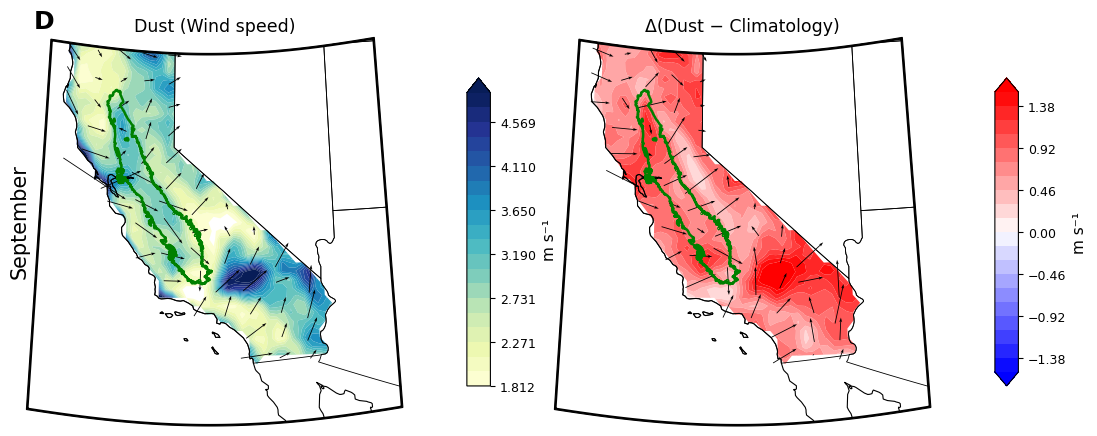

In [38]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_WIND_NC = "s_clim_wind_all.nc"
DUST_WIND_NC = "s_wind_dusty.nc"

CLIM_U_NC = "s_clim_u_all.nc"
CLIM_V_NC = "s_clim_v_all.nc"
DUST_U_NC = "s_u_dusty.nc"
DUST_V_NC = "s_v_dusty.nc"

VAR_WIND_PREF = "wind"
YEARS = (2005, 2024)
CV_SHP = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG = "sep_wind.png"

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_var(ds: xr.Dataset, preferred: str | None):
    if preferred and preferred in ds.data_vars:
        return preferred
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_ms_if_needed(da: xr.DataArray) -> xr.DataArray:
    units = str(da.attrs.get("units", "")).lower()
    out = da
    if "knot" in units or units in ("kt", "kts"):
        out = da * 0.514444
        out.attrs.update(da.attrs); out.attrs["units"] = "m s-1"
    elif "km/h" in units or "km h" in units or "kph" in units:
        out = da * (1000.0/3600.0)
        out.attrs.update(da.attrs); out.attrs["units"] = "m s-1"
    return out

def open_speed(path_nc, var_pref):
    ds = xr.open_dataset(path_nc)
    ds = unify_time(rename_lonlat(ds))
    vn = pick_var(ds, var_pref)
    da = ds[vn].transpose("time","lat","lon")
    da = fix_lon_range(da).sortby("time")
    da = to_ms_if_needed(da)
    return da

def open_uv(u_path, v_path):
    ds_u = unify_time(rename_lonlat(xr.open_dataset(u_path)))
    ds_v = unify_time(rename_lonlat(xr.open_dataset(v_path)))
    u_vn = pick_var(ds_u, None); v_vn = pick_var(ds_v, None)
    U = ds_u[u_vn].transpose("time","lat","lon")
    V = ds_v[v_vn].transpose("time","lat","lon")
    U = fix_lon_range(to_ms_if_needed(U)).sortby("time")
    V = fix_lon_range(to_ms_if_needed(V)).sortby("time")
    return U, V

def quiver_sample(lon, lat, U, V, target=22):
    nlon = lon.size; nlat = lat.size
    step_x = max(1, nlon // target)
    step_y = max(1, nlat // target)
    lon2d, lat2d = np.meshgrid(lon, lat)
    L = lon2d[::step_y, ::step_x]
    B = lat2d[::step_y, ::step_x]
    UU = U[::step_y, ::step_x]
    VV = V[::step_y, ::step_x]
    m = np.isfinite(UU) & np.isfinite(VV)
    return L[m], B[m], UU[m], VV[m]

def choose_refspeed(U, V):
    spd = np.hypot(U, V)
    q = np.nanpercentile(spd, 90)
    for r in (2, 5, 10, 15, 20, 25):
        if q <= r: return r
    return 30

# =======================
# Load & average
# =======================
wind_dust = open_speed(DUST_WIND_NC, VAR_WIND_PREF)
wind_clim = open_speed(CLIM_WIND_NC, VAR_WIND_PREF)

if YEARS is not None:
    for name in ("wind_dust","wind_clim"):
        da = locals()[name]
        t = pd.to_datetime(da["time"].values)
        m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
        if m.any(): locals()[name] = da.isel(time=np.where(m)[0])

if not (np.array_equal(wind_clim.lon.values, wind_dust.lon.values) and
        np.array_equal(wind_clim.lat.values, wind_dust.lat.values)):
    wind_clim = wind_clim.interp(lon=wind_dust.lon, lat=wind_dust.lat)

clim_mean = wind_clim.mean("time", keep_attrs=True)
dust_mean = wind_dust.mean("time", keep_attrs=True)
anom_mean = dust_mean - clim_mean  # speed anomaly (m s-1)

U_clim, V_clim = open_uv(CLIM_U_NC, CLIM_V_NC)
U_dust, V_dust = open_uv(DUST_U_NC, DUST_V_NC)

for nmU, nmV in (("U_clim","V_clim"), ("U_dust","V_dust")):
    if not (np.array_equal(locals()[nmU].lon.values, wind_dust.lon.values) and
            np.array_equal(locals()[nmU].lat.values, wind_dust.lat.values)):
        locals()[nmU] = locals()[nmU].interp(lon=wind_dust.lon, lat=wind_dust.lat)
        locals()[nmV] = locals()[nmV].interp(lon=wind_dust.lon, lat=wind_dust.lat)

if YEARS is not None:
    for nmU, nmV in (("U_clim","V_clim"), ("U_dust","V_dust")):
        daU, daV = locals()[nmU], locals()[nmV]
        t = pd.to_datetime(daU["time"].values)
        m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
        if m.any():
            locals()[nmU] = daU.isel(time=np.where(m)[0])
            locals()[nmV] = daV.isel(time=np.where(m)[0])

Ucm = U_clim.mean("time"); Vcm = V_clim.mean("time")
Udm = U_dust.mean("time");  Vdm = V_dust.mean("time")
Uanom = Udm - Ucm;          Vanom = Vdm - Vcm

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs=4326)

mask = regionmask.mask_geopandas(ca_gdf, wind_dust.lon.values, wind_dust.lat.values)

dust_ca  = dust_mean.where(~np.isnan(mask))
anom_ca  = anom_mean.where(~np.isnan(mask))
Udm_ca   = Udm.where(~np.isnan(mask)); Vdm_ca = Vdm.where(~np.isnan(mask))
Uanom_ca = Uanom.where(~np.isnan(mask)); Vanom_ca = Vanom.where(~np.isnan(mask))

print(f"CA mean wind (dust): {area_weighted_mean_2d(dust_ca):.2f} m s-1")
print(f"CA mean wind anomaly (dust−clim): {area_weighted_mean_2d(anom_ca):+.2f} m s-1")

# =======================
# PLOT — Left: dust; Right: anomaly
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(wind_dust.lon.values, wind_dust.lat.values)

# Color scales
# Dust speed (robust 2–98% from dust only)
vmin_d = float(np.nanpercentile(dust_ca.values, 2))
vmax_d = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin_d) or not np.isfinite(vmax_d) or vmin_d >= vmax_d:
    vmin_d, vmax_d = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_d = np.linspace(vmin_d, vmax_d, 21)

# Anomaly (symmetric by robust |98%|)
rob = float(np.nanpercentile(np.abs(anom_ca.values), 98))
vlim_a = max(0.2, rob)  # ensure nonzero
levels_a = np.linspace(-vlim_a, vlim_a, 21)

# CV outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, U, V, levels, cmap, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels, cmap=cmap,
                     extend="both" if cmap == "bwr" else "max",
                     transform=ccrs.PlateCarree(), antialiased=True)
    # quivers
    L, B, UU, VV = quiver_sample(field.lon.values, field.lat.values, U.values, V.values, target=22)
    q = ax.quiver(L, B, UU, VV, transform=ccrs.PlateCarree(),
                  pivot="mid", width=0.0022, headwidth=3.5, headlength=5.5)
    ref = choose_refspeed(UU, VV)
    #ax.quiverkey(q, 0.02, 0.05, ref, f"{ref} m s⁻¹", labelpos="E", coordinates="axes")
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout: [Dust][Anomaly] with one colorbar beside each
fig = plt.figure(figsize=(12.8, 5.0))

gs  = fig.add_gridspec(nrows=1, ncols=4, width_ratios=[0.8, 0.05, 0.8, 0.05], wspace=0.32)

ax_dust = fig.add_subplot(gs[0, 0], projection=proj)
cax_d   = fig.add_subplot(gs[0, 1])
ax_anom = fig.add_subplot(gs[0, 2], projection=proj)
cax_a   = fig.add_subplot(gs[0, 3])

cf_d = draw_map(ax_dust, dust_ca, Udm_ca, Vdm_ca, levels_d, "YlGnBu", "Dust (Wind speed)")
cf_a = draw_map(ax_anom, anom_ca, Uanom_ca, Vanom_ca, levels_a, "bwr", "Δ(Dust − Climatology)")

# Colorbars
for cax, cf, label in ((cax_d, cf_d, "m s⁻¹"),
                       (cax_a, cf_a, "m s⁻¹")):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + 0.06, pos.width, pos.height * 0.80])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "D",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.12, 0.5, "September", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()


CA mean wind (dust): 3.25 m s-1
CA mean wind anomaly (dust−clim): +1.10 m s-1


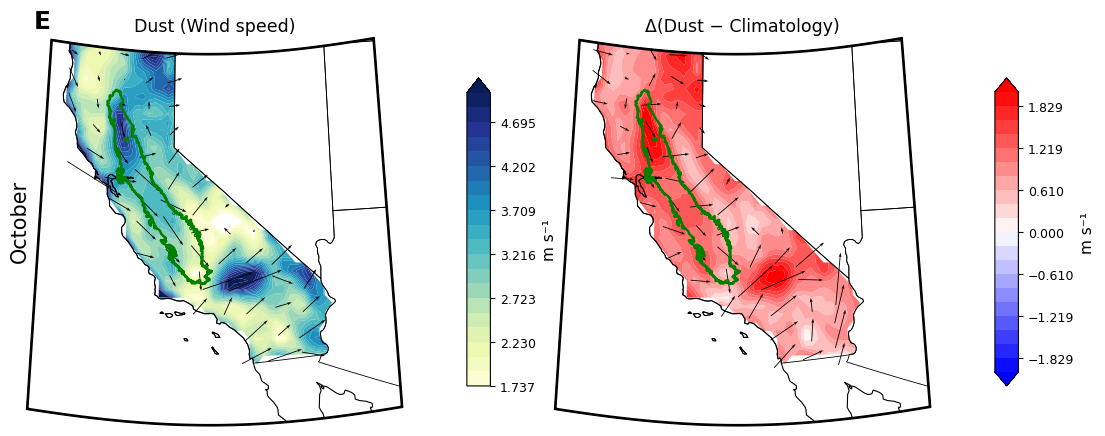

In [40]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_WIND_NC = "o_clim_wind_all.nc"
DUST_WIND_NC = "o_wind_dusty.nc"

CLIM_U_NC = "o_clim_u_all.nc"
CLIM_V_NC = "o_clim_v_all.nc"
DUST_U_NC = "o_u_dusty.nc"
DUST_V_NC = "o_v_dusty.nc"

VAR_WIND_PREF = "wind"
YEARS = (2005, 2024)
CV_SHP = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG = "oct_wind.png"

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_var(ds: xr.Dataset, preferred: str | None):
    if preferred and preferred in ds.data_vars:
        return preferred
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_ms_if_needed(da: xr.DataArray) -> xr.DataArray:
    units = str(da.attrs.get("units", "")).lower()
    out = da
    if "knot" in units or units in ("kt", "kts"):
        out = da * 0.514444
        out.attrs.update(da.attrs); out.attrs["units"] = "m s-1"
    elif "km/h" in units or "km h" in units or "kph" in units:
        out = da * (1000.0/3600.0)
        out.attrs.update(da.attrs); out.attrs["units"] = "m s-1"
    return out

def open_speed(path_nc, var_pref):
    ds = xr.open_dataset(path_nc)
    ds = unify_time(rename_lonlat(ds))
    vn = pick_var(ds, var_pref)
    da = ds[vn].transpose("time","lat","lon")
    da = fix_lon_range(da).sortby("time")
    da = to_ms_if_needed(da)
    return da

def open_uv(u_path, v_path):
    ds_u = unify_time(rename_lonlat(xr.open_dataset(u_path)))
    ds_v = unify_time(rename_lonlat(xr.open_dataset(v_path)))
    u_vn = pick_var(ds_u, None); v_vn = pick_var(ds_v, None)
    U = ds_u[u_vn].transpose("time","lat","lon")
    V = ds_v[v_vn].transpose("time","lat","lon")
    U = fix_lon_range(to_ms_if_needed(U)).sortby("time")
    V = fix_lon_range(to_ms_if_needed(V)).sortby("time")
    return U, V

def quiver_sample(lon, lat, U, V, target=22):
    nlon = lon.size; nlat = lat.size
    step_x = max(1, nlon // target)
    step_y = max(1, nlat // target)
    lon2d, lat2d = np.meshgrid(lon, lat)
    L = lon2d[::step_y, ::step_x]
    B = lat2d[::step_y, ::step_x]
    UU = U[::step_y, ::step_x]
    VV = V[::step_y, ::step_x]
    m = np.isfinite(UU) & np.isfinite(VV)
    return L[m], B[m], UU[m], VV[m]

def choose_refspeed(U, V):
    spd = np.hypot(U, V)
    q = np.nanpercentile(spd, 90)
    for r in (2, 5, 10, 15, 20, 25):
        if q <= r: return r
    return 30

# =======================
# Load & average
# =======================
wind_dust = open_speed(DUST_WIND_NC, VAR_WIND_PREF)
wind_clim = open_speed(CLIM_WIND_NC, VAR_WIND_PREF)

if YEARS is not None:
    for name in ("wind_dust","wind_clim"):
        da = locals()[name]
        t = pd.to_datetime(da["time"].values)
        m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
        if m.any(): locals()[name] = da.isel(time=np.where(m)[0])

if not (np.array_equal(wind_clim.lon.values, wind_dust.lon.values) and
        np.array_equal(wind_clim.lat.values, wind_dust.lat.values)):
    wind_clim = wind_clim.interp(lon=wind_dust.lon, lat=wind_dust.lat)

clim_mean = wind_clim.mean("time", keep_attrs=True)
dust_mean = wind_dust.mean("time", keep_attrs=True)
anom_mean = dust_mean - clim_mean  # speed anomaly (m s-1)

U_clim, V_clim = open_uv(CLIM_U_NC, CLIM_V_NC)
U_dust, V_dust = open_uv(DUST_U_NC, DUST_V_NC)

for nmU, nmV in (("U_clim","V_clim"), ("U_dust","V_dust")):
    if not (np.array_equal(locals()[nmU].lon.values, wind_dust.lon.values) and
            np.array_equal(locals()[nmU].lat.values, wind_dust.lat.values)):
        locals()[nmU] = locals()[nmU].interp(lon=wind_dust.lon, lat=wind_dust.lat)
        locals()[nmV] = locals()[nmV].interp(lon=wind_dust.lon, lat=wind_dust.lat)

if YEARS is not None:
    for nmU, nmV in (("U_clim","V_clim"), ("U_dust","V_dust")):
        daU, daV = locals()[nmU], locals()[nmV]
        t = pd.to_datetime(daU["time"].values)
        m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
        if m.any():
            locals()[nmU] = daU.isel(time=np.where(m)[0])
            locals()[nmV] = daV.isel(time=np.where(m)[0])

Ucm = U_clim.mean("time"); Vcm = V_clim.mean("time")
Udm = U_dust.mean("time");  Vdm = V_dust.mean("time")
Uanom = Udm - Ucm;          Vanom = Vdm - Vcm

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs=4326)

mask = regionmask.mask_geopandas(ca_gdf, wind_dust.lon.values, wind_dust.lat.values)

dust_ca  = dust_mean.where(~np.isnan(mask))
anom_ca  = anom_mean.where(~np.isnan(mask))
Udm_ca   = Udm.where(~np.isnan(mask)); Vdm_ca = Vdm.where(~np.isnan(mask))
Uanom_ca = Uanom.where(~np.isnan(mask)); Vanom_ca = Vanom.where(~np.isnan(mask))

print(f"CA mean wind (dust): {area_weighted_mean_2d(dust_ca):.2f} m s-1")
print(f"CA mean wind anomaly (dust−clim): {area_weighted_mean_2d(anom_ca):+.2f} m s-1")

# =======================
# PLOT — Left: dust; Right: anomaly
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(wind_dust.lon.values, wind_dust.lat.values)

# Color scales
# Dust speed (robust 2–98% from dust only)
vmin_d = float(np.nanpercentile(dust_ca.values, 2))
vmax_d = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin_d) or not np.isfinite(vmax_d) or vmin_d >= vmax_d:
    vmin_d, vmax_d = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_d = np.linspace(vmin_d, vmax_d, 21)

# Anomaly (symmetric by robust |98%|)
rob = float(np.nanpercentile(np.abs(anom_ca.values), 98))
vlim_a = max(0.2, rob)  # ensure nonzero
levels_a = np.linspace(-vlim_a, vlim_a, 21)

# CV outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, U, V, levels, cmap, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels, cmap=cmap,
                     extend="both" if cmap == "bwr" else "max",
                     transform=ccrs.PlateCarree(), antialiased=True)
    # quivers
    L, B, UU, VV = quiver_sample(field.lon.values, field.lat.values, U.values, V.values, target=22)
    q = ax.quiver(L, B, UU, VV, transform=ccrs.PlateCarree(),
                  pivot="mid", width=0.0022, headwidth=3.5, headlength=5.5)
    ref = choose_refspeed(UU, VV)
    #ax.quiverkey(q, 0.02, 0.05, ref, f"{ref} m s⁻¹", labelpos="E", coordinates="axes")
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout: [Dust][Anomaly] with one colorbar beside each
fig = plt.figure(figsize=(12.8, 5.0))

gs  = fig.add_gridspec(nrows=1, ncols=4, width_ratios=[0.8, 0.05, 0.8, 0.05], wspace=0.32)

ax_dust = fig.add_subplot(gs[0, 0], projection=proj)
cax_d   = fig.add_subplot(gs[0, 1])
ax_anom = fig.add_subplot(gs[0, 2], projection=proj)
cax_a   = fig.add_subplot(gs[0, 3])

cf_d = draw_map(ax_dust, dust_ca, Udm_ca, Vdm_ca, levels_d, "YlGnBu", "Dust (Wind speed)")
cf_a = draw_map(ax_anom, anom_ca, Uanom_ca, Vanom_ca, levels_a, "bwr", "Δ(Dust − Climatology)")

# Colorbars
for cax, cf, label in ((cax_d, cf_d, "m s⁻¹"),
                       (cax_a, cf_a, "m s⁻¹")):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + 0.06, pos.width, pos.height * 0.80])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "E",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.12, 0.5, "October", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()


CA mean wind (dust): 3.13 m s-1
CA mean wind anomaly (dust−clim): +1.00 m s-1


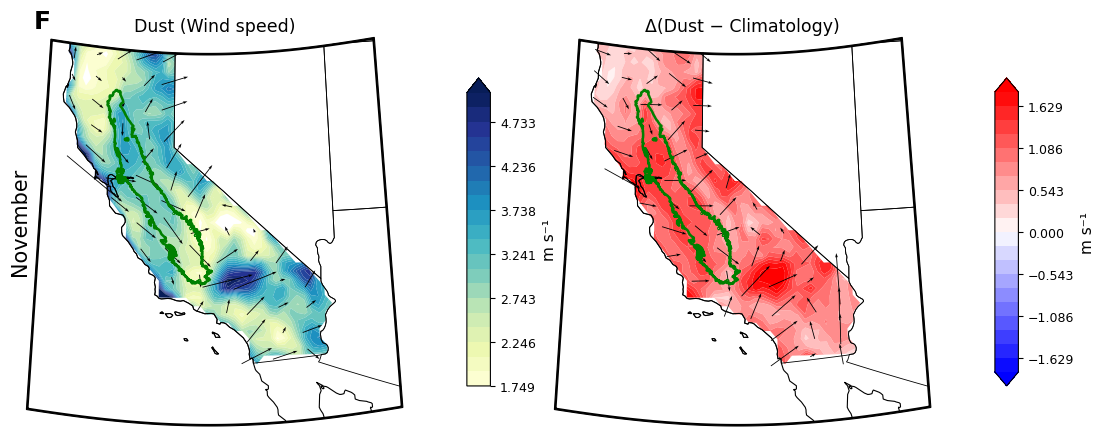

In [41]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader
import regionmask

# =======================
# INPUTS
# =======================
CLIM_WIND_NC = "n_clim_wind_all.nc"
DUST_WIND_NC = "n_wind_dusty.nc"

CLIM_U_NC = "n_clim_u_all.nc"
CLIM_V_NC = "n_clim_v_all.nc"
DUST_U_NC = "n_u_dusty.nc"
DUST_V_NC = "n_v_dusty.nc"

VAR_WIND_PREF = "wind"
YEARS = (2005, 2024)
CV_SHP = "central_valley_alluvial_boundary_usgs.shp"
OUT_PNG = "nov_wind.png"

BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# =======================
# Helpers
# =======================
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    else:
        ren = {}
        if "longitude" in obj.dims: ren["longitude"] = "lon"
        if "latitude"  in obj.dims: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj

def unify_time(ds: xr.Dataset) -> xr.Dataset:
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    raise ValueError(f"No recognizable time coord in {list(ds.coords)}")

def fix_lon_range(da: xr.DataArray) -> xr.DataArray:
    lon_name = "lon" if "lon" in da.coords else "longitude"
    if float(da[lon_name].max()) > 180:
        da = da.assign_coords({lon_name: (((da[lon_name] + 180) % 360) - 180)}).sortby(lon_name)
    return da

def area_weighted_mean_2d(da: xr.DataArray) -> float:
    w = np.cos(np.deg2rad(da["lat"]))
    w = w / w.mean()
    return float((da * w).mean(("lat","lon")).values)

def pick_var(ds: xr.Dataset, preferred: str | None):
    if preferred and preferred in ds.data_vars:
        return preferred
    for vn, da in ds.data_vars.items():
        dims = set(da.dims)
        if (("lat" in dims or "latitude" in dims) and
            ("lon" in dims or "longitude" in dims) and
            ("time" in dims or "day" in dims or "valid_time" in dims)):
            return vn
    return list(ds.data_vars)[0]

def to_ms_if_needed(da: xr.DataArray) -> xr.DataArray:
    units = str(da.attrs.get("units", "")).lower()
    out = da
    if "knot" in units or units in ("kt", "kts"):
        out = da * 0.514444
        out.attrs.update(da.attrs); out.attrs["units"] = "m s-1"
    elif "km/h" in units or "km h" in units or "kph" in units:
        out = da * (1000.0/3600.0)
        out.attrs.update(da.attrs); out.attrs["units"] = "m s-1"
    return out

def open_speed(path_nc, var_pref):
    ds = xr.open_dataset(path_nc)
    ds = unify_time(rename_lonlat(ds))
    vn = pick_var(ds, var_pref)
    da = ds[vn].transpose("time","lat","lon")
    da = fix_lon_range(da).sortby("time")
    da = to_ms_if_needed(da)
    return da

def open_uv(u_path, v_path):
    ds_u = unify_time(rename_lonlat(xr.open_dataset(u_path)))
    ds_v = unify_time(rename_lonlat(xr.open_dataset(v_path)))
    u_vn = pick_var(ds_u, None); v_vn = pick_var(ds_v, None)
    U = ds_u[u_vn].transpose("time","lat","lon")
    V = ds_v[v_vn].transpose("time","lat","lon")
    U = fix_lon_range(to_ms_if_needed(U)).sortby("time")
    V = fix_lon_range(to_ms_if_needed(V)).sortby("time")
    return U, V

def quiver_sample(lon, lat, U, V, target=22):
    nlon = lon.size; nlat = lat.size
    step_x = max(1, nlon // target)
    step_y = max(1, nlat // target)
    lon2d, lat2d = np.meshgrid(lon, lat)
    L = lon2d[::step_y, ::step_x]
    B = lat2d[::step_y, ::step_x]
    UU = U[::step_y, ::step_x]
    VV = V[::step_y, ::step_x]
    m = np.isfinite(UU) & np.isfinite(VV)
    return L[m], B[m], UU[m], VV[m]

def choose_refspeed(U, V):
    spd = np.hypot(U, V)
    q = np.nanpercentile(spd, 90)
    for r in (2, 5, 10, 15, 20, 25):
        if q <= r: return r
    return 30

# =======================
# Load & average
# =======================
wind_dust = open_speed(DUST_WIND_NC, VAR_WIND_PREF)
wind_clim = open_speed(CLIM_WIND_NC, VAR_WIND_PREF)

if YEARS is not None:
    for name in ("wind_dust","wind_clim"):
        da = locals()[name]
        t = pd.to_datetime(da["time"].values)
        m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
        if m.any(): locals()[name] = da.isel(time=np.where(m)[0])

if not (np.array_equal(wind_clim.lon.values, wind_dust.lon.values) and
        np.array_equal(wind_clim.lat.values, wind_dust.lat.values)):
    wind_clim = wind_clim.interp(lon=wind_dust.lon, lat=wind_dust.lat)

clim_mean = wind_clim.mean("time", keep_attrs=True)
dust_mean = wind_dust.mean("time", keep_attrs=True)
anom_mean = dust_mean - clim_mean  # speed anomaly (m s-1)

U_clim, V_clim = open_uv(CLIM_U_NC, CLIM_V_NC)
U_dust, V_dust = open_uv(DUST_U_NC, DUST_V_NC)

for nmU, nmV in (("U_clim","V_clim"), ("U_dust","V_dust")):
    if not (np.array_equal(locals()[nmU].lon.values, wind_dust.lon.values) and
            np.array_equal(locals()[nmU].lat.values, wind_dust.lat.values)):
        locals()[nmU] = locals()[nmU].interp(lon=wind_dust.lon, lat=wind_dust.lat)
        locals()[nmV] = locals()[nmV].interp(lon=wind_dust.lon, lat=wind_dust.lat)

if YEARS is not None:
    for nmU, nmV in (("U_clim","V_clim"), ("U_dust","V_dust")):
        daU, daV = locals()[nmU], locals()[nmV]
        t = pd.to_datetime(daU["time"].values)
        m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
        if m.any():
            locals()[nmU] = daU.isel(time=np.where(m)[0])
            locals()[nmV] = daV.isel(time=np.where(m)[0])

Ucm = U_clim.mean("time"); Vcm = V_clim.mean("time")
Udm = U_dust.mean("time");  Vdm = V_dust.mean("time")
Uanom = Udm - Ucm;          Vanom = Vdm - Vcm

# =======================
# California mask
# =======================
ne_path = shapereader.natural_earth("50m", "cultural", "admin_1_states_provinces")
states_gdf = gpd.read_file(ne_path).to_crs(4326)
geom = states_gdf.query("name == 'California' and adm0_a3 == 'USA'").geometry
ca_poly = geom.union_all() if hasattr(geom, "union_all") else geom.unary_union
ca_gdf  = gpd.GeoDataFrame(geometry=[ca_poly.buffer(0.05)], crs=4326)

mask = regionmask.mask_geopandas(ca_gdf, wind_dust.lon.values, wind_dust.lat.values)

dust_ca  = dust_mean.where(~np.isnan(mask))
anom_ca  = anom_mean.where(~np.isnan(mask))
Udm_ca   = Udm.where(~np.isnan(mask)); Vdm_ca = Vdm.where(~np.isnan(mask))
Uanom_ca = Uanom.where(~np.isnan(mask)); Vanom_ca = Vanom.where(~np.isnan(mask))

print(f"CA mean wind (dust): {area_weighted_mean_2d(dust_ca):.2f} m s-1")
print(f"CA mean wind anomaly (dust−clim): {area_weighted_mean_2d(anom_ca):+.2f} m s-1")

# =======================
# PLOT — Left: dust; Right: anomaly
# =======================
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)
lon2d, lat2d = np.meshgrid(wind_dust.lon.values, wind_dust.lat.values)

# Color scales
# Dust speed (robust 2–98% from dust only)
vmin_d = float(np.nanpercentile(dust_ca.values, 2))
vmax_d = float(np.nanpercentile(dust_ca.values, 98))
if not np.isfinite(vmin_d) or not np.isfinite(vmax_d) or vmin_d >= vmax_d:
    vmin_d, vmax_d = float(np.nanmin(dust_ca.values)), float(np.nanmax(dust_ca.values))
levels_d = np.linspace(vmin_d, vmax_d, 21)

# Anomaly (symmetric by robust |98%|)
rob = float(np.nanpercentile(np.abs(anom_ca.values), 98))
vlim_a = max(0.2, rob)  # ensure nonzero
levels_a = np.linspace(-vlim_a, vlim_a, 21)

# CV outline (optional)
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(4326)
except Exception:
    cv_gdf = None

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none", linewidth=1.8, zorder=8)

def draw_map(ax, field, U, V, levels, cmap, title):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    cf = ax.contourf(lon2d, lat2d, field.values, levels=levels, cmap=cmap,
                     extend="both" if cmap == "bwr" else "max",
                     transform=ccrs.PlateCarree(), antialiased=True)
    # quivers
    L, B, UU, VV = quiver_sample(field.lon.values, field.lat.values, U.values, V.values, target=22)
    q = ax.quiver(L, B, UU, VV, transform=ccrs.PlateCarree(),
                  pivot="mid", width=0.0022, headwidth=3.5, headlength=5.5)
    ref = choose_refspeed(UU, VV)
    #ax.quiverkey(q, 0.02, 0.05, ref, f"{ref} m s⁻¹", labelpos="E", coordinates="axes")
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)
    ax.set_title(title, fontsize=12.5, pad=4)
    ax.set_rasterization_zorder(1)
    return cf

# Layout: [Dust][Anomaly] with one colorbar beside each
fig = plt.figure(figsize=(12.8, 5.0))

gs  = fig.add_gridspec(nrows=1, ncols=4, width_ratios=[0.8, 0.05, 0.8, 0.05], wspace=0.32)

ax_dust = fig.add_subplot(gs[0, 0], projection=proj)
cax_d   = fig.add_subplot(gs[0, 1])
ax_anom = fig.add_subplot(gs[0, 2], projection=proj)
cax_a   = fig.add_subplot(gs[0, 3])

cf_d = draw_map(ax_dust, dust_ca, Udm_ca, Vdm_ca, levels_d, "YlGnBu", "Dust (Wind speed)")
cf_a = draw_map(ax_anom, anom_ca, Uanom_ca, Vanom_ca, levels_a, "bwr", "Δ(Dust − Climatology)")

# Colorbars
for cax, cf, label in ((cax_d, cf_d, "m s⁻¹"),
                       (cax_a, cf_a, "m s⁻¹")):
    pos = cax.get_position()
    cax.set_position([pos.x0, pos.y0 + 0.06, pos.width, pos.height * 0.80])
    cb = fig.colorbar(cf, cax=cax, orientation="vertical")
    cb.set_label(label, fontsize=11)
    cb.ax.tick_params(labelsize=9)

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "F",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.12, 0.5, "November", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()


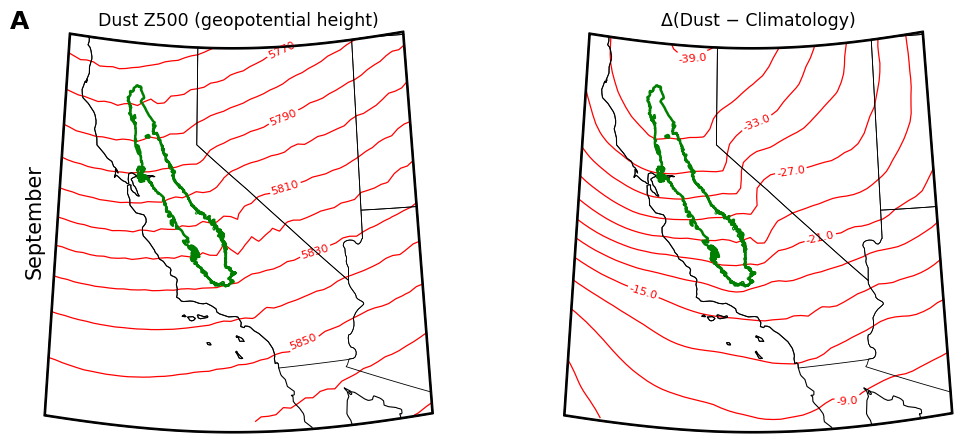

Saved: sep_z.png


In [44]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader

# -------------------- Inputs --------------------
CLIM_NC = "s_clim_z_all.nc"
DUSTY_NC = "s_dusty_z.nc"
OUT_PNG = "sep_z.png"
CV_SHP  = "central_valley_alluvial_boundary_usgs.shp"
YEARS   = (2005, 2024)

# Plotting box (no masking, just crop)
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# -------------------- Utilities --------------------
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    ren = {}
    if "longitude" in obj.dims: ren["longitude"] = "lon"
    if "latitude"  in obj.dims: ren["latitude"]  = "lat"
    return obj.rename(ren) if ren else obj

def unify_time(ds):
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    return ds

def normalize_lon(da):
    """Ensure longitude in [-180,180] and sorted."""
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lon = da[lon_name]
    if float(lon.max()) > 180:
        da = da.assign_coords({lon_name: ((lon + 180) % 360) - 180})
    return da.sortby(lon_name)

def fix_lon_range(da):
    # legacy alias; keep both just in case
    return normalize_lon(da)

def select_500hpa_dataset(ds):
    """Pick nearest 500 hPa level and squeeze it out (handles Pa/hPa)."""
    level_keys = ["pressure_level","level","lev","plev","isobaricInhPa","isobaricInPa","pressure"]
    for lev in level_keys:
        if lev in ds.dims or lev in ds.coords:
            vals = xr.DataArray(ds[lev]).values.astype(float).ravel()
            target = 50000.0 if np.nanmax(vals) > 2000 else 500.0
            try:
                ds = ds.sel({lev: target}, method="nearest")
            except Exception:
                idx = int(np.nanargmin(np.abs(vals - target)))
                ds = ds.isel({lev: idx})
            ds = ds.squeeze(drop=True)
            break
    return ds

def pick_z_var(ds):
    for vn in ["z","gh","hgt","z500","gh500","gph","geopotential","geopotential_height"]:
        if vn in ds.data_vars: return ds[vn]
    return next(iter(ds.data_vars.values()))

def to_height_m(da):
    units = str(da.attrs.get("units","")).lower()
    g = 9.80665
    looks_phi = any(s in units for s in ["m2 s-2","m^2 s^-2","m2/s2","j kg-1","j/kg","geopotential"])
    med = float(np.nanmedian(da.values)) if da.size else np.nan
    if looks_phi or (np.isfinite(med) and med > 10000):
        out = da / g
        out.attrs.update(da.attrs); out.attrs["units"] = "m"; out.attrs["long_name"] = "Geopotential height"
        return out
    if "units" not in da.attrs: da.attrs["units"] = "m"
    if "long_name" not in da.attrs: da.attrs["long_name"] = "Geopotential height"
    return da

def crop_to_box_safe(da, lon0, lon1, lat0, lat1):
    """Box crop that works for ascending/descending lat and 0–360/±180 lon."""
    da = normalize_lon(da)
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lat_name = "lat" if "lat" in da.coords else "latitude"

    lo, hi = (min(lon0, lon1), max(lon0, lon1))
    la, lb = (min(lat0, lat1), max(lat0, lat1))

    window = ((da[lon_name] >= lo) & (da[lon_name] <= hi) &
              (da[lat_name] >= la) & (da[lat_name] <= lb))
    da_box = da.where(window, drop=True)

    if da_box.sizes.get(lat_name, 0) == 0 or da_box.sizes.get(lon_name, 0) == 0:
        lon_min, lon_max = float(da[lon_name].min()), float(da[lon_name].max())
        lat_min, lat_max = float(da[lat_name].min()), float(da[lat_name].max())
        raise ValueError(
            f"No data inside box [{lo},{hi}]x[{la},{lb}]. "
            f"Data lon range=({lon_min},{lon_max}), lat range=({lat_min},{lat_max})."
        )
    return da_box

def finite_bounds(a, qlo=2, qhi=98):
    """Percentile bounds on finite values with safe fallback."""
    vals = np.asarray(a)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None, None
    return float(np.nanpercentile(vals, qlo)), float(np.nanpercentile(vals, qhi))

def nice_step(vmin, vmax, target_n=22, minimum=10.0):
    span = max(vmax - vmin, 1.0)
    rough = span / max(target_n, 1)
    step  = round(rough / 10.0) * 10.0
    return max(minimum, step if step else minimum)

# -------------------- Load data --------------------
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = select_500hpa_dataset(unify_time(rename_lonlat(ds_dust)))
z_dust  = to_height_m(fix_lon_range(pick_z_var(ds_dust))).transpose(..., "lat","lon")
if "time" not in z_dust.dims: raise ValueError("Dust file has no time dimension.")
z_dust = z_dust.transpose("time","lat","lon").sortby("time")

ds_clim = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds_clim = select_500hpa_dataset(unify_time(rename_lonlat(ds_clim)))
z_clim  = to_height_m(fix_lon_range(pick_z_var(ds_clim))).transpose(..., "lat","lon")
if "time" not in z_clim.dims: raise ValueError("Climatology file has no time dimension.")
z_clim = z_clim.transpose("time","lat","lon").sortby("time")

if YEARS is not None:
    t = pd.to_datetime(z_clim["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any(): z_clim = z_clim.isel(time=np.where(m)[0])

# Align grids
if not (np.array_equal(z_clim.lon.values, z_dust.lon.values) and
        np.array_equal(z_clim.lat.values, z_dust.lat.values)):
    z_clim = z_clim.interp(lon=z_dust.lon, lat=z_dust.lat)

# Means (unmasked)
dust_mean = z_dust.mean("time", keep_attrs=True)
clim_mean = z_clim.mean("time", keep_attrs=True)
anom      = dust_mean - clim_mean

# Crop to plotting box (no masking)
dust_box = crop_to_box_safe(dust_mean, BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)
anom_box = crop_to_box_safe(anom,      BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

# -------------------- Contour levels --------------------
vmin, vmax = finite_bounds(dust_box.values, 2, 98)
if vmin is None or vmax is None or not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    finite = np.asarray(dust_box.values)[np.isfinite(dust_box.values)]
    if finite.size == 0:
        raise ValueError("Dust field has no finite values after cropping.")
    vmin, vmax = float(finite.min()), float(finite.max())

step_d = nice_step(vmin, vmax, target_n=22, minimum=10.0)
levels_dust = np.arange(np.floor(vmin/step_d)*step_d,
                        np.ceil(vmax/step_d)*step_d + 0.1, step_d)

alim_lo, _ = finite_bounds(np.abs(anom_box.values), 98, 98)
alim = max(alim_lo or 2.0, 2.0)
step_a = max(2.0, round((2*alim) / 24.0))     # ~24 lines
amax = np.ceil(alim / step_a) * step_a
levels_anom = np.arange(-amax, amax + 0.1, step_a)

# Meshes (in case sorting changed)
lon2d_d, lat2d_d = np.meshgrid(dust_box["lon"].values, dust_box["lat"].values)
lon2d_a, lat2d_a = np.meshgrid(anom_box["lon"].values, anom_box["lat"].values)

# -------------------- Plotting (contours only, unmasked) --------------------
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)

# Optional CV overlay
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    pass

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none",
                          linewidth=1.8, zorder=8)

def draw_contours(ax, lon2d, lat2d, field, levels, color="red", linewidth=0.9, label_fmt="%.0f"):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)

    cs = ax.contour(lon2d, lat2d, field.values, levels=levels,
                    colors=color, linewidths=linewidth, linestyles='solid',
                    transform=ccrs.PlateCarree())
    if len(cs.levels) > 1:
        ax.clabel(cs, cs.levels[::2], inline=True, fmt=label_fmt, fontsize=8)

    # Emphasize zero line for anomalies
    if np.nanmin(levels) < 0 < np.nanmax(levels):
        ax.contour(lon2d, lat2d, field.values, levels=[0],
                   colors="k", linewidths=1.5, transform=ccrs.PlateCarree())
    return cs

fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.0], wspace=0.10)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)

draw_contours(ax1, lon2d_d, lat2d_d, dust_box, levels_dust, color="red", linewidth=0.9, label_fmt="%.0f")
ax1.set_title("Dust Z500 (geopotential height)", fontsize=12.5, pad=4)

draw_contours(ax2, lon2d_a, lat2d_a, anom_box, levels_anom, color="red", linewidth=0.9, label_fmt="%.1f")
ax2.set_title("Δ(Dust − Climatology)", fontsize=12.5, pad=4)

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "A",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.15, 0.5, "September", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


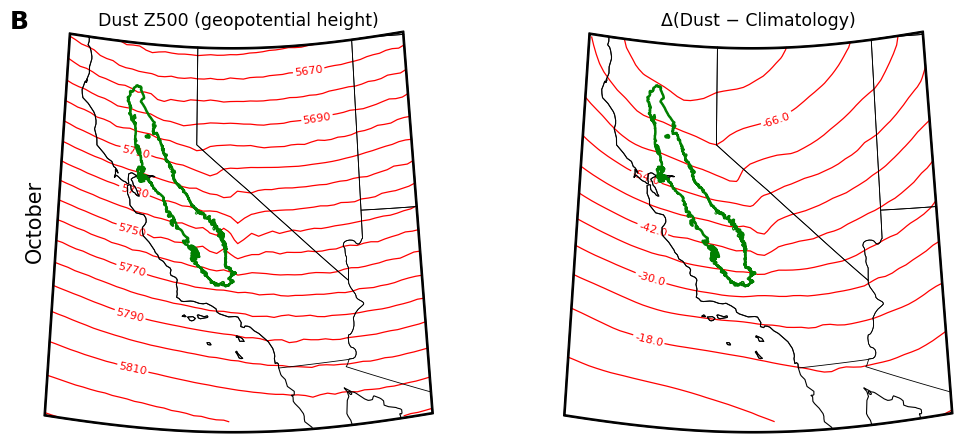

Saved: oct_z.png


In [45]:

import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader

# -------------------- Inputs --------------------
CLIM_NC = "o_clim_z_all.nc"
DUSTY_NC = "o_dusty_z.nc"
OUT_PNG = "oct_z.png"
CV_SHP  = "central_valley_alluvial_boundary_usgs.shp"
YEARS   = (2005, 2024)

# Plotting box (no masking, just crop)
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# -------------------- Utilities --------------------
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    ren = {}
    if "longitude" in obj.dims: ren["longitude"] = "lon"
    if "latitude"  in obj.dims: ren["latitude"]  = "lat"
    return obj.rename(ren) if ren else obj

def unify_time(ds):
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    return ds

def normalize_lon(da):
    """Ensure longitude in [-180,180] and sorted."""
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lon = da[lon_name]
    if float(lon.max()) > 180:
        da = da.assign_coords({lon_name: ((lon + 180) % 360) - 180})
    return da.sortby(lon_name)

def fix_lon_range(da):
    # legacy alias; keep both just in case
    return normalize_lon(da)

def select_500hpa_dataset(ds):
    """Pick nearest 500 hPa level and squeeze it out (handles Pa/hPa)."""
    level_keys = ["pressure_level","level","lev","plev","isobaricInhPa","isobaricInPa","pressure"]
    for lev in level_keys:
        if lev in ds.dims or lev in ds.coords:
            vals = xr.DataArray(ds[lev]).values.astype(float).ravel()
            target = 50000.0 if np.nanmax(vals) > 2000 else 500.0
            try:
                ds = ds.sel({lev: target}, method="nearest")
            except Exception:
                idx = int(np.nanargmin(np.abs(vals - target)))
                ds = ds.isel({lev: idx})
            ds = ds.squeeze(drop=True)
            break
    return ds

def pick_z_var(ds):
    for vn in ["z","gh","hgt","z500","gh500","gph","geopotential","geopotential_height"]:
        if vn in ds.data_vars: return ds[vn]
    return next(iter(ds.data_vars.values()))

def to_height_m(da):
    units = str(da.attrs.get("units","")).lower()
    g = 9.80665
    looks_phi = any(s in units for s in ["m2 s-2","m^2 s^-2","m2/s2","j kg-1","j/kg","geopotential"])
    med = float(np.nanmedian(da.values)) if da.size else np.nan
    if looks_phi or (np.isfinite(med) and med > 10000):
        out = da / g
        out.attrs.update(da.attrs); out.attrs["units"] = "m"; out.attrs["long_name"] = "Geopotential height"
        return out
    if "units" not in da.attrs: da.attrs["units"] = "m"
    if "long_name" not in da.attrs: da.attrs["long_name"] = "Geopotential height"
    return da

def crop_to_box_safe(da, lon0, lon1, lat0, lat1):
    """Box crop that works for ascending/descending lat and 0–360/±180 lon."""
    da = normalize_lon(da)
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lat_name = "lat" if "lat" in da.coords else "latitude"

    lo, hi = (min(lon0, lon1), max(lon0, lon1))
    la, lb = (min(lat0, lat1), max(lat0, lat1))

    window = ((da[lon_name] >= lo) & (da[lon_name] <= hi) &
              (da[lat_name] >= la) & (da[lat_name] <= lb))
    da_box = da.where(window, drop=True)

    if da_box.sizes.get(lat_name, 0) == 0 or da_box.sizes.get(lon_name, 0) == 0:
        lon_min, lon_max = float(da[lon_name].min()), float(da[lon_name].max())
        lat_min, lat_max = float(da[lat_name].min()), float(da[lat_name].max())
        raise ValueError(
            f"No data inside box [{lo},{hi}]x[{la},{lb}]. "
            f"Data lon range=({lon_min},{lon_max}), lat range=({lat_min},{lat_max})."
        )
    return da_box

def finite_bounds(a, qlo=2, qhi=98):
    """Percentile bounds on finite values with safe fallback."""
    vals = np.asarray(a)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None, None
    return float(np.nanpercentile(vals, qlo)), float(np.nanpercentile(vals, qhi))

def nice_step(vmin, vmax, target_n=22, minimum=10.0):
    span = max(vmax - vmin, 1.0)
    rough = span / max(target_n, 1)
    step  = round(rough / 10.0) * 10.0
    return max(minimum, step if step else minimum)

# -------------------- Load data --------------------
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = select_500hpa_dataset(unify_time(rename_lonlat(ds_dust)))
z_dust  = to_height_m(fix_lon_range(pick_z_var(ds_dust))).transpose(..., "lat","lon")
if "time" not in z_dust.dims: raise ValueError("Dust file has no time dimension.")
z_dust = z_dust.transpose("time","lat","lon").sortby("time")

ds_clim = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds_clim = select_500hpa_dataset(unify_time(rename_lonlat(ds_clim)))
z_clim  = to_height_m(fix_lon_range(pick_z_var(ds_clim))).transpose(..., "lat","lon")
if "time" not in z_clim.dims: raise ValueError("Climatology file has no time dimension.")
z_clim = z_clim.transpose("time","lat","lon").sortby("time")

if YEARS is not None:
    t = pd.to_datetime(z_clim["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any(): z_clim = z_clim.isel(time=np.where(m)[0])

# Align grids
if not (np.array_equal(z_clim.lon.values, z_dust.lon.values) and
        np.array_equal(z_clim.lat.values, z_dust.lat.values)):
    z_clim = z_clim.interp(lon=z_dust.lon, lat=z_dust.lat)

# Means (unmasked)
dust_mean = z_dust.mean("time", keep_attrs=True)
clim_mean = z_clim.mean("time", keep_attrs=True)
anom      = dust_mean - clim_mean

# Crop to plotting box (no masking)
dust_box = crop_to_box_safe(dust_mean, BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)
anom_box = crop_to_box_safe(anom,      BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

# -------------------- Contour levels --------------------
vmin, vmax = finite_bounds(dust_box.values, 2, 98)
if vmin is None or vmax is None or not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    finite = np.asarray(dust_box.values)[np.isfinite(dust_box.values)]
    if finite.size == 0:
        raise ValueError("Dust field has no finite values after cropping.")
    vmin, vmax = float(finite.min()), float(finite.max())

step_d = nice_step(vmin, vmax, target_n=22, minimum=10.0)
levels_dust = np.arange(np.floor(vmin/step_d)*step_d,
                        np.ceil(vmax/step_d)*step_d + 0.1, step_d)

alim_lo, _ = finite_bounds(np.abs(anom_box.values), 98, 98)
alim = max(alim_lo or 2.0, 2.0)
step_a = max(2.0, round((2*alim) / 24.0))     # ~24 lines
amax = np.ceil(alim / step_a) * step_a
levels_anom = np.arange(-amax, amax + 0.1, step_a)

# Meshes (in case sorting changed)
lon2d_d, lat2d_d = np.meshgrid(dust_box["lon"].values, dust_box["lat"].values)
lon2d_a, lat2d_a = np.meshgrid(anom_box["lon"].values, anom_box["lat"].values)

# -------------------- Plotting (contours only, unmasked) --------------------
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)

# Optional CV overlay
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    pass

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none",
                          linewidth=1.8, zorder=8)

def draw_contours(ax, lon2d, lat2d, field, levels, color="red", linewidth=0.9, label_fmt="%.0f"):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)

    cs = ax.contour(lon2d, lat2d, field.values, levels=levels,
                    colors=color, linewidths=linewidth, linestyles='solid',
                    transform=ccrs.PlateCarree())
    if len(cs.levels) > 1:
        ax.clabel(cs, cs.levels[::2], inline=True, fmt=label_fmt, fontsize=8)

    # Emphasize zero line for anomalies
    if np.nanmin(levels) < 0 < np.nanmax(levels):
        ax.contour(lon2d, lat2d, field.values, levels=[0],
                   colors="k", linewidths=1.5, transform=ccrs.PlateCarree())
    return cs

fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.0], wspace=0.10)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)

draw_contours(ax1, lon2d_d, lat2d_d, dust_box, levels_dust, color="red", linewidth=0.9, label_fmt="%.0f")
ax1.set_title("Dust Z500 (geopotential height)", fontsize=12.5, pad=4)

draw_contours(ax2, lon2d_a, lat2d_a, anom_box, levels_anom, color="red", linewidth=0.9, label_fmt="%.1f")
ax2.set_title("Δ(Dust − Climatology)", fontsize=12.5, pad=4)

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "B",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.15, 0.5, "October", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")


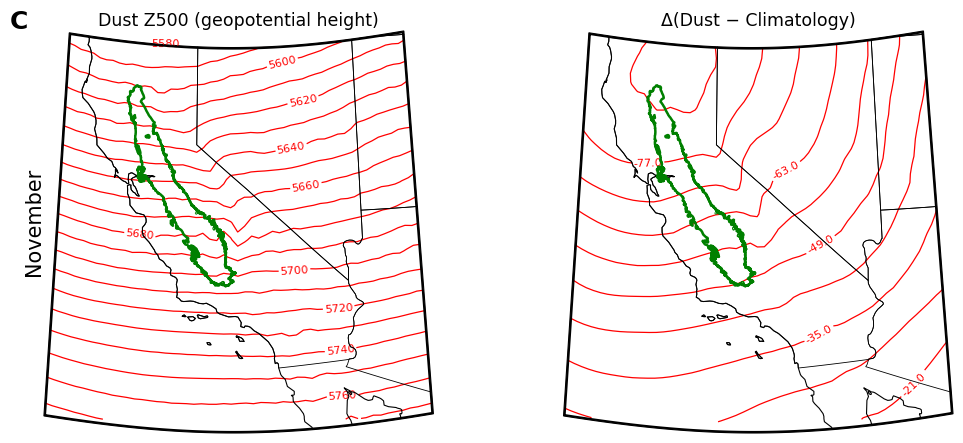

Saved: nov_z.png


In [46]:
import numpy as np, pandas as pd, xarray as xr, matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from matplotlib.path import Path as MplPath
from matplotlib.patches import PathPatch
from pathlib import Path as PPath
import geopandas as gpd
from cartopy.io import shapereader

# -------------------- Inputs --------------------
CLIM_NC = "n_clim_z_all.nc"
DUSTY_NC = "n_dusty_z.nc"
OUT_PNG = "nov_z.png"
CV_SHP  = "central_valley_alluvial_boundary_usgs.shp"
YEARS   = (2005, 2024)

# Plotting box (no masking, just crop)
BOX_LON0, BOX_LON1 = -125.0, -112.0
BOX_LAT0, BOX_LAT1 =   31.0,   42.1

# -------------------- Utilities --------------------
def build_box_path(lon0, lon1, lat0, lat1, amp_top=0.28, amp_bot=0.32, n=200):
    f = np.linspace(0, 1, n)
    top    = np.column_stack((np.linspace(lon0, lon1, n), lat1 - amp_top*np.sin(np.pi*f)))
    right  = np.column_stack(([lon1]*n, np.linspace(lat1, lat0, n)))
    bottom = np.column_stack((np.linspace(lon1, lon0, n), lat0 - amp_bot*np.sin(np.pi*f)))
    left   = np.column_stack(([lon0]*n, np.linspace(lat0, lat1, n)))
    pts    = np.vstack([top, right, bottom, left, top[:1]])
    codes  = [MplPath.MOVETO] + [MplPath.LINETO]*(len(pts)-2) + [MplPath.CLOSEPOLY]
    return MplPath(pts, codes)

def clip_to_path(ax, path, linewidth=3, edgecolor="black"):
    ax.set_boundary(path, transform=ccrs.PlateCarree())
    ax.patch.set_facecolor("none")
    ax.add_patch(PathPatch(path, transform=ccrs.PlateCarree(),
                           facecolor="none", edgecolor=edgecolor,
                           linewidth=linewidth, zorder=10))

def rename_lonlat(obj):
    if isinstance(obj, xr.Dataset):
        ren = {}
        if "longitude" in obj.coords: ren["longitude"] = "lon"
        if "latitude"  in obj.coords: ren["latitude"]  = "lat"
        return obj.rename(ren) if ren else obj
    ren = {}
    if "longitude" in obj.dims: ren["longitude"] = "lon"
    if "latitude"  in obj.dims: ren["latitude"]  = "lat"
    return obj.rename(ren) if ren else obj

def unify_time(ds):
    if "time" in ds.coords: return ds
    for cand in ("date","valid_time"):
        if cand in ds.coords: return ds.rename({cand:"time"})
    return ds

def normalize_lon(da):
    """Ensure longitude in [-180,180] and sorted."""
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lon = da[lon_name]
    if float(lon.max()) > 180:
        da = da.assign_coords({lon_name: ((lon + 180) % 360) - 180})
    return da.sortby(lon_name)

def fix_lon_range(da):
    # legacy alias; keep both just in case
    return normalize_lon(da)

def select_500hpa_dataset(ds):
    """Pick nearest 500 hPa level and squeeze it out (handles Pa/hPa)."""
    level_keys = ["pressure_level","level","lev","plev","isobaricInhPa","isobaricInPa","pressure"]
    for lev in level_keys:
        if lev in ds.dims or lev in ds.coords:
            vals = xr.DataArray(ds[lev]).values.astype(float).ravel()
            target = 50000.0 if np.nanmax(vals) > 2000 else 500.0
            try:
                ds = ds.sel({lev: target}, method="nearest")
            except Exception:
                idx = int(np.nanargmin(np.abs(vals - target)))
                ds = ds.isel({lev: idx})
            ds = ds.squeeze(drop=True)
            break
    return ds

def pick_z_var(ds):
    for vn in ["z","gh","hgt","z500","gh500","gph","geopotential","geopotential_height"]:
        if vn in ds.data_vars: return ds[vn]
    return next(iter(ds.data_vars.values()))

def to_height_m(da):
    units = str(da.attrs.get("units","")).lower()
    g = 9.80665
    looks_phi = any(s in units for s in ["m2 s-2","m^2 s^-2","m2/s2","j kg-1","j/kg","geopotential"])
    med = float(np.nanmedian(da.values)) if da.size else np.nan
    if looks_phi or (np.isfinite(med) and med > 10000):
        out = da / g
        out.attrs.update(da.attrs); out.attrs["units"] = "m"; out.attrs["long_name"] = "Geopotential height"
        return out
    if "units" not in da.attrs: da.attrs["units"] = "m"
    if "long_name" not in da.attrs: da.attrs["long_name"] = "Geopotential height"
    return da

def crop_to_box_safe(da, lon0, lon1, lat0, lat1):
    """Box crop that works for ascending/descending lat and 0–360/±180 lon."""
    da = normalize_lon(da)
    lon_name = "lon" if "lon" in da.coords else "longitude"
    lat_name = "lat" if "lat" in da.coords else "latitude"

    lo, hi = (min(lon0, lon1), max(lon0, lon1))
    la, lb = (min(lat0, lat1), max(lat0, lat1))

    window = ((da[lon_name] >= lo) & (da[lon_name] <= hi) &
              (da[lat_name] >= la) & (da[lat_name] <= lb))
    da_box = da.where(window, drop=True)

    if da_box.sizes.get(lat_name, 0) == 0 or da_box.sizes.get(lon_name, 0) == 0:
        lon_min, lon_max = float(da[lon_name].min()), float(da[lon_name].max())
        lat_min, lat_max = float(da[lat_name].min()), float(da[lat_name].max())
        raise ValueError(
            f"No data inside box [{lo},{hi}]x[{la},{lb}]. "
            f"Data lon range=({lon_min},{lon_max}), lat range=({lat_min},{lat_max})."
        )
    return da_box

def finite_bounds(a, qlo=2, qhi=98):
    """Percentile bounds on finite values with safe fallback."""
    vals = np.asarray(a)
    vals = vals[np.isfinite(vals)]
    if vals.size == 0:
        return None, None
    return float(np.nanpercentile(vals, qlo)), float(np.nanpercentile(vals, qhi))

def nice_step(vmin, vmax, target_n=22, minimum=10.0):
    span = max(vmax - vmin, 1.0)
    rough = span / max(target_n, 1)
    step  = round(rough / 10.0) * 10.0
    return max(minimum, step if step else minimum)

# -------------------- Load data --------------------
ds_dust = xr.open_dataset(DUSTY_NC)
ds_dust = select_500hpa_dataset(unify_time(rename_lonlat(ds_dust)))
z_dust  = to_height_m(fix_lon_range(pick_z_var(ds_dust))).transpose(..., "lat","lon")
if "time" not in z_dust.dims: raise ValueError("Dust file has no time dimension.")
z_dust = z_dust.transpose("time","lat","lon").sortby("time")

ds_clim = xr.open_dataset(CLIM_NC, decode_cf=True, mask_and_scale=True)
ds_clim = select_500hpa_dataset(unify_time(rename_lonlat(ds_clim)))
z_clim  = to_height_m(fix_lon_range(pick_z_var(ds_clim))).transpose(..., "lat","lon")
if "time" not in z_clim.dims: raise ValueError("Climatology file has no time dimension.")
z_clim = z_clim.transpose("time","lat","lon").sortby("time")

if YEARS is not None:
    t = pd.to_datetime(z_clim["time"].values)
    m = (t >= f"{YEARS[0]}-01-01") & (t <= f"{YEARS[1]}-12-31")
    if m.any(): z_clim = z_clim.isel(time=np.where(m)[0])

# Align grids
if not (np.array_equal(z_clim.lon.values, z_dust.lon.values) and
        np.array_equal(z_clim.lat.values, z_dust.lat.values)):
    z_clim = z_clim.interp(lon=z_dust.lon, lat=z_dust.lat)

# Means (unmasked)
dust_mean = z_dust.mean("time", keep_attrs=True)
clim_mean = z_clim.mean("time", keep_attrs=True)
anom      = dust_mean - clim_mean

# Crop to plotting box (no masking)
dust_box = crop_to_box_safe(dust_mean, BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)
anom_box = crop_to_box_safe(anom,      BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1)

# -------------------- Contour levels --------------------
vmin, vmax = finite_bounds(dust_box.values, 2, 98)
if vmin is None or vmax is None or not np.isfinite(vmin) or not np.isfinite(vmax) or vmin >= vmax:
    finite = np.asarray(dust_box.values)[np.isfinite(dust_box.values)]
    if finite.size == 0:
        raise ValueError("Dust field has no finite values after cropping.")
    vmin, vmax = float(finite.min()), float(finite.max())

step_d = nice_step(vmin, vmax, target_n=22, minimum=10.0)
levels_dust = np.arange(np.floor(vmin/step_d)*step_d,
                        np.ceil(vmax/step_d)*step_d + 0.1, step_d)

alim_lo, _ = finite_bounds(np.abs(anom_box.values), 98, 98)
alim = max(alim_lo or 2.0, 2.0)
step_a = max(2.0, round((2*alim) / 24.0))     # ~24 lines
amax = np.ceil(alim / step_a) * step_a
levels_anom = np.arange(-amax, amax + 0.1, step_a)

# Meshes (in case sorting changed)
lon2d_d, lat2d_d = np.meshgrid(dust_box["lon"].values, dust_box["lat"].values)
lon2d_a, lat2d_a = np.meshgrid(anom_box["lon"].values, anom_box["lat"].values)

# -------------------- Plotting (contours only, unmasked) --------------------
proj = ccrs.LambertConformal(central_longitude=-119, central_latitude=37,
                             standard_parallels=(33, 45))
box_path = build_box_path(BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1, 0.28, 0.32)

# Optional CV overlay
cv_gdf = None
try:
    if PPath(CV_SHP).exists():
        cv_gdf = gpd.read_file(CV_SHP).to_crs(epsg=4326)
except Exception:
    pass

def add_cv(ax):
    if cv_gdf is not None:
        ax.add_geometries(cv_gdf.geometry, crs=ccrs.PlateCarree(),
                          edgecolor="green", facecolor="none",
                          linewidth=1.8, zorder=8)

def draw_contours(ax, lon2d, lat2d, field, levels, color="red", linewidth=0.9, label_fmt="%.0f"):
    clip_to_path(ax, box_path, linewidth=3.0, edgecolor="black")
    ax.set_extent([BOX_LON0, BOX_LON1, BOX_LAT0, BOX_LAT1], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE.with_scale("50m"), linewidth=0.8, zorder=6)
    ax.add_feature(cfeature.STATES.with_scale("50m"),   linewidth=0.6, zorder=6)
    add_cv(ax)

    cs = ax.contour(lon2d, lat2d, field.values, levels=levels,
                    colors=color, linewidths=linewidth, linestyles='solid',
                    transform=ccrs.PlateCarree())
    if len(cs.levels) > 1:
        ax.clabel(cs, cs.levels[::2], inline=True, fmt=label_fmt, fontsize=8)

    # Emphasize zero line for anomalies
    if np.nanmin(levels) < 0 < np.nanmax(levels):
        ax.contour(lon2d, lat2d, field.values, levels=[0],
                   colors="k", linewidths=1.5, transform=ccrs.PlateCarree())
    return cs

fig = plt.figure(figsize=(12.8, 5.0))
gs  = fig.add_gridspec(1, 2, width_ratios=[1.0, 1.0], wspace=0.10)

ax1 = fig.add_subplot(gs[0, 0], projection=proj)
ax2 = fig.add_subplot(gs[0, 1], projection=proj)

draw_contours(ax1, lon2d_d, lat2d_d, dust_box, levels_dust, color="red", linewidth=0.9, label_fmt="%.0f")
ax1.set_title("Dust Z500 (geopotential height)", fontsize=12.5, pad=4)

draw_contours(ax2, lon2d_a, lat2d_a, anom_box, levels_anom, color="red", linewidth=0.9, label_fmt="%.1f")
ax2.set_title("Δ(Dust − Climatology)", fontsize=12.5, pad=4)

b = ax_dust.get_position()
fig.text(b.x0 + 0.02 * b.width, b.y1 + 0.008, "C",
         ha="left", va="bottom", fontsize=18, fontweight="bold", fontfamily="sans-serif")

fig.text(0.15, 0.5, "November", rotation=90,
         va="center", ha="center", fontsize=15)

fig.savefig(OUT_PNG, dpi=500, bbox_inches="tight")
plt.show()
print(f"Saved: {OUT_PNG}")
